In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pylab import *
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import SG as SG
import layers_calc_numba
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [2]:
# Some parameters
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots

In [4]:
tau = ['50', '250', '1000', '2000']
#tau = ['50', '250', '500' , '1000', '2000']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/Vary_N/'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'m/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

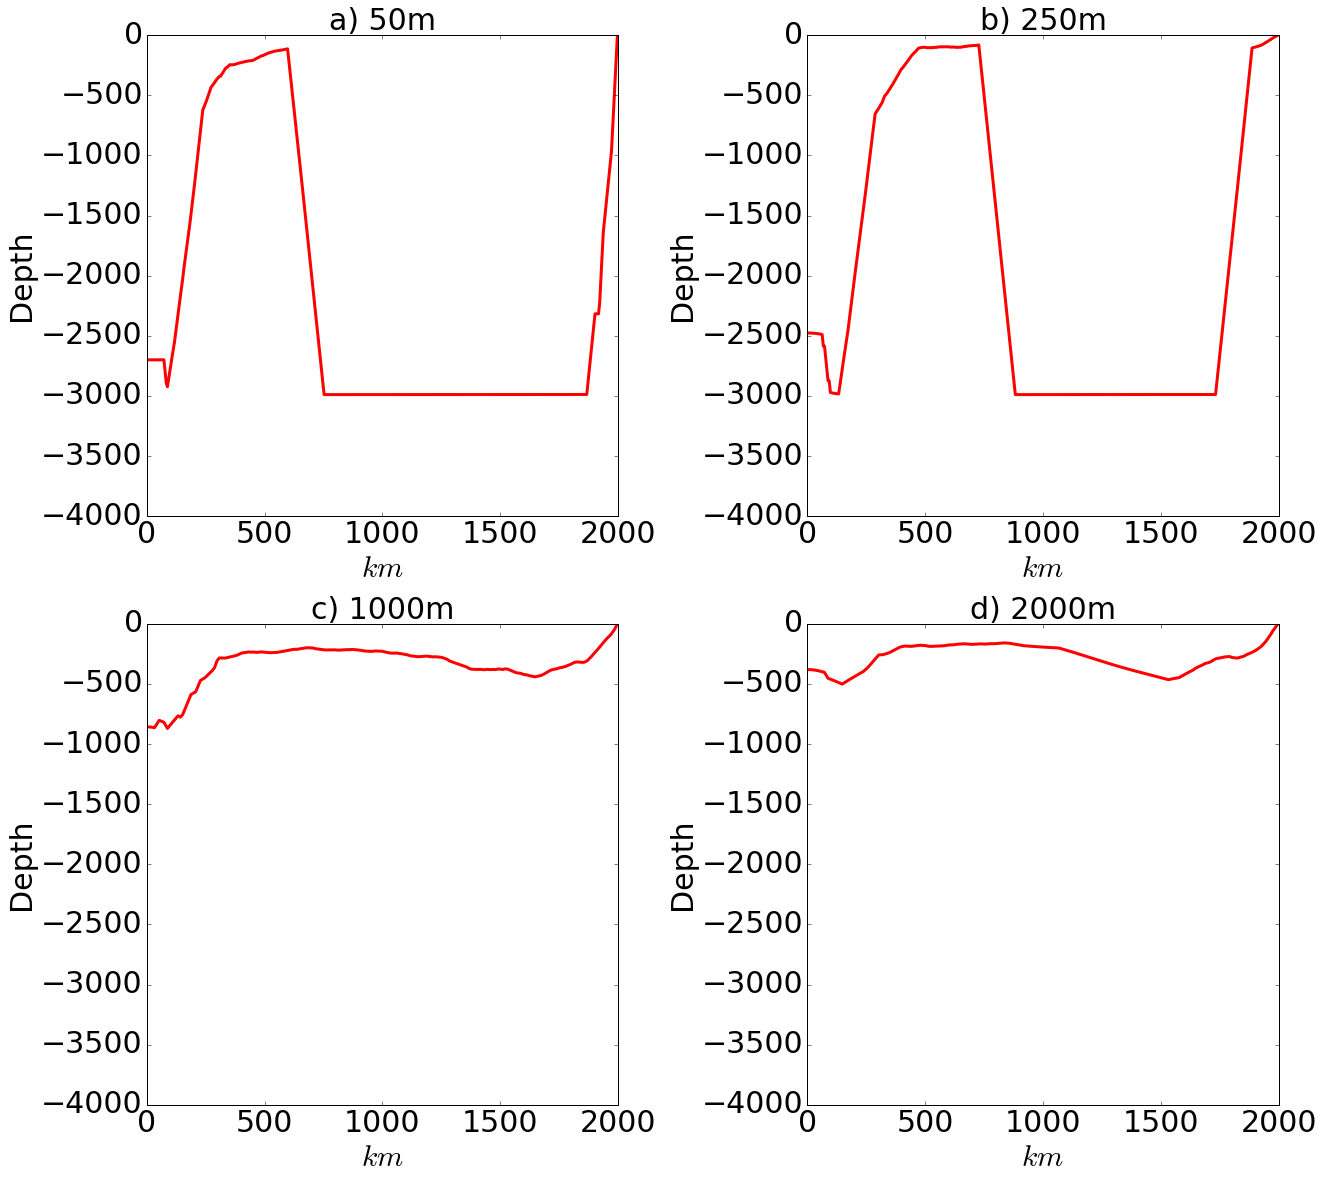

In [18]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'m/'
    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(c.yc))

    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<1)[0]
        b = indx#[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[1]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            a = a-1
        DDL[jj] = depths[a,jj]

    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000, SG.savitzky_golay(-DDL,31,1), 'r', linewidth=3)
    plt.ylim(-4000,0)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'m', fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()